## Imports

In [1]:
import copy
import itertools
import logging
import math
from functools import partial
from pathlib import Path
from typing import Dict
import json

import hydra
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import omegaconf
import pytorch_lightning
import seaborn as sns
import torch  # noqa
import wandb
from hydra.utils import instantiate
from matplotlib import tri
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from omegaconf import DictConfig
from pytorch_lightning import LightningModule
from scipy.stats import qmc
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler
from tqdm import tqdm

from nn_core.callbacks import NNTemplateCore
from nn_core.common import PROJECT_ROOT
from nn_core.common.utils import seed_index_everything
from nn_core.model_logging import NNLogger

import ccmm  # noqa
from ccmm.matching.utils import (
    apply_permutation_to_statedict,
    get_all_symbols_combinations,
    load_permutations,
    perm_indices_to_perm_matrix,
    plot_permutation_history_animation,
    restore_original_weights,
)
from ccmm.utils.utils import (
    fuse_batch_norm_into_conv,
    get_interpolated_loss_acc_curves,
    l2_norm_models,
    linear_interpolate,
    load_model_from_info,
    map_model_seed_to_symbol,
    normalize_unit_norm,
    project_onto,
    save_factored_permutations,
    vector_to_state_dict,
)

/home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104warnERKNS_7WarningE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
    }
)
sns.set_context("talk")

cmap_name = "coolwarm_r"

from ccmm.utils.plot import Palette

palette = Palette(f"{PROJECT_ROOT}/misc/palette2.json")
palette

{'light red': '#c05761',
 'green': '#2a9d8f',
 'yellow': '#e9c46a',
 'dark blue': '#264653',
 'red': '#941c2f',
 'orange': '#e76f51',
 'violet': '#734f5a',
 'light orange': '#f4a261'}

In [3]:
logging.getLogger("lightning.pytorch").setLevel(logging.WARNING)
logging.getLogger("torch").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)
pylogger = logging.getLogger(__name__)

## Configuration

In [4]:
%load_ext autoreload
%autoreload 2

import hydra
from hydra import initialize, compose
from typing import Dict, List

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path=str("../conf"), job_name="matching")

hydra.initialize()

In [5]:
cfg = compose(config_name="matching", overrides=["model=mlp", "dataset=emnist"])

In [6]:
core_cfg = cfg  # NOQA
cfg = cfg.matching

seed_index_everything(cfg)

2025-01-07 14:34:38 INFO     Global seed set to 1273642419                      ]8;id=824445;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py\pytorch_lightning.utilities.seed]8;;\:]8;id=752914;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py#71\71]8;;\

                    INFO     Setting seed 1273642419 from seeds[1]                         ]8;id=904482;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/nn_core/common/utils.py\nn_core.common.utils]8;;\:]8;id=488394;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/nn_core/common/utils.py#107\107]8;;\

1273642419

## Hyperparameters

In [7]:
num_test_samples = 5000
num_train_samples = 10000

## Load dataset

In [8]:
transform = instantiate(core_cfg.dataset.test.transform)

train_dataset = instantiate(core_cfg.dataset.train, transform=transform)
test_dataset = instantiate(core_cfg.dataset.test, transform=transform)

train_subset = Subset(train_dataset, list(range(num_train_samples)))
train_loader = DataLoader(train_subset, batch_size=5000, num_workers=cfg.num_workers)

test_subset = Subset(test_dataset, list(range(num_test_samples)))

test_loader = DataLoader(test_subset, batch_size=1000, num_workers=cfg.num_workers)

/media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/data/EMNIST/raw/emnist-letters-train-images-idx3-ubyte /media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/data/EMNIST/raw/emnist-letters-train-labels-idx1-ubyte
/media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/data/EMNIST/raw/emnist-letters-test-images-idx3-ubyte /media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/data/EMNIST/raw/emnist-letters-test-labels-idx1-ubyte


In [9]:
trainer = instantiate(cfg.trainer, enable_progress_bar=False, enable_model_summary=False)

/home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(


                    INFO     GPU available: True (cuda), used: True      ]8;id=118512;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=499288;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1751\1751]8;;\

                    INFO     TPU available: False, using: 0 TPU cores    ]8;id=215118;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=143249;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1754\1754]8;;\

                    INFO     IPU available: False, using: 0 IPUs         ]8;id=768303;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=365854;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1757\1757]8;;\

                    INFO     HPU available: False, using: 0 HPUs         ]8;id=464800;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=343238;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1760\1760]8;;\

## Load models

In [10]:
from ccmm.utils.utils import load_model_from_artifact

run = wandb.init(project=core_cfg.core.project_name, entity=core_cfg.core.entity, job_type="matching")

# {a: 1, b: 2, c: 3, ..}
symbols_to_seed: Dict[int, str] = {map_model_seed_to_symbol(seed): seed for seed in cfg.model_seeds}

artifact_path = (
    lambda seed: f"{core_cfg.core.entity}/{core_cfg.core.project_name}/{core_cfg.dataset.name}_{core_cfg.model.model_identifier}_{seed}:latest"
)

# {a: model_a, b: model_b, c: model_c, ..}
models: Dict[str, LightningModule] = {
    map_model_seed_to_symbol(seed): load_model_from_artifact(run, artifact_path(seed)) for seed in cfg.model_seeds
}
model_orig_weights = {symbol: copy.deepcopy(model.model.state_dict()) for symbol, model in models.items()}

num_models = len(models)

pylogger.info(f"Using {num_models} models with architecture {core_cfg.model.model_identifier}")

                    ERROR    Failed to detect the name of this notebook, you can set it manually  ]8;id=700264;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/wandb/jupyter.py\wandb.jupyter]8;;\:]8;id=645850;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/wandb/jupyter.py#224\224]8;;\
                             with the WANDB_NOTEBOOK_NAME environment variable to enable code                      
                             saving.                                                                               

wandb: Currently logged in as: crisostomi (gladia). Use `wandb login --relogin` to force relogin


2025-01-07 14:34:42 INFO     Trying to load                                                    ]8;id=260230;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=131413;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py#264\264]8;;\
                             gladia/cycle-consistent-model-merging/EMNIST_MLP_1:latest                             

wandb:   1 of 1 files downloaded.  


2025-01-07 14:34:44 INFO     Trying to load                                                    ]8;id=682161;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=77612;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py#264\264]8;;\
                             gladia/cycle-consistent-model-merging/EMNIST_MLP_2:latest                             

wandb:   1 of 1 files downloaded.  


2025-01-07 14:34:45 INFO     Using 2 models with architecture MLP                                       ]8;id=679197;file:///tmp/ipykernel_132860/4100191972.py\__main__]8;;\:]8;id=551854;file:///tmp/ipykernel_132860/4100191972.py#20\20]8;;\

## Match models

In [11]:
# always permute the model having larger character order, i.e. c -> b, b -> a and so on ...
from ccmm.matching.matcher import GitRebasinMatcher
from ccmm.matching.utils import get_inverse_permutations

symbols = set(symbols_to_seed.keys())
sorted_symbols = sorted(symbols, reverse=False)
fixed_symbol, permutee_symbol = "a", "b"
fixed_model, permutee_model = models[fixed_symbol].cpu(), models[permutee_symbol].cpu()

In [12]:
from ccmm.matching.permutation_spec import MLPPermutationSpecBuilder, CNNPermutationSpecBuilder

permutation_spec_builder = MLPPermutationSpecBuilder(num_hidden_layers=4)
# permutation_spec_builder = CNNPermutationSpecBuilder()
permutation_spec = permutation_spec_builder.create_permutation_spec()

ref_model = list(models.values())[0]
assert set(permutation_spec.layer_and_axes_to_perm.keys()) == set(ref_model.model.state_dict().keys())

### Func maps Weight matching

In [13]:
restore_original_weights(models, model_orig_weights)

In [14]:
from ccmm.matching.func_maps import FM_to_p2p, graph_zoomout_refine

w_descrs = 0.5
w_laps = 1
w_dcomms = 1

num_neighbors = 5

InitFM_mode = "identity"

num_zoomout_iters = 20
step = 1
opt_descriptor_type = "weights"  # "weights", "features", "features_denoised", "eigenneurons", "spectral"
mode = "connectivity"  # connectivity, distance

In [15]:
# dicts for permutations and permuted params, D[a][b] refers to the permutation/params to map b -> a
func_permutations = {symb: {other_symb: None for other_symb in symbols.difference(symb)} for symb in symbols}

In [16]:
from typing import Tuple
from ccmm.matching.func_maps import compute_eigenvectors, fit_func_map
from ccmm.matching.permutation_spec import PermutationSpec
from ccmm.matching.utils import get_permuted_param, perm_cols, perm_matrix_to_perm_indices, perm_rows
from ccmm.matching.weight_matching import (
    LayerIterationOrder,
    compute_weights_similarity,
    get_layer_iteration_order,
    solve_linear_assignment_problem,
)


def func_weight_matching(
    ps: PermutationSpec,
    fixed,
    permutee,
    max_iter=100,
    init_perm=None,
    layer_iteration_order: LayerIterationOrder = LayerIterationOrder.RANDOM,
    verbose=False,
    method="func",
):
    """
    Find a permutation of params_b to make them match params_a.

    :param ps: PermutationSpec
    :param target: the parameters to match
    :param to_permute: the parameters to permute
    """

    if not verbose:
        pylogger.setLevel(logging.WARNING)

    params_a, params_b = fixed, permutee

    perm_sizes = {}

    for p, params_and_axes in ps.perm_to_layers_and_axes.items():

        # p is the permutation matrix name, e.g. P_0, P_1, ..
        # params_and_axes is a list of tuples, each tuple contains the name of the parameter and the axis on which the permutation matrix acts

        # it is enough to select a single parameter and axis, since all the parameters permuted by the same matrix have the same shape
        ref_tuple = params_and_axes[0]
        ref_param_name = ref_tuple[0]
        ref_axis = ref_tuple[1]

        perm_sizes[p] = params_a[ref_param_name].shape[ref_axis]

    # initialize with identity permutation if none given
    all_perm_indices = {p: torch.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
    # e.g. P0, P1, ..
    perm_names = list(all_perm_indices.keys())

    num_layers = len(perm_names)

    for iteration in tqdm(range(max_iter), desc="Weight matching"):
        progress = False

        perm_order = get_layer_iteration_order(layer_iteration_order, num_layers)

        for p_ix in perm_order:
            print(f"Permuting {perm_names[p_ix]}")

            p = perm_names[p_ix]
            num_neurons = perm_sizes[p]

            # all the params that are permuted by this permutation matrix, together with the axis on which it acts
            # e.g. ('layer_0.weight', 0), ('layer_0.bias', 0), ('layer_1.weight', 0)..
            params_and_axes: List[Tuple[str, int]] = ps.perm_to_layers_and_axes[p]
            # sort by axis, so that we can permute the columns of the weight matrices first
            params_and_axes = sorted(params_and_axes, key=lambda x: x[1])
            # filter out bias
            params_and_axes = [x for x in params_and_axes if "bias" not in x[0]]

            # TODO: check if this is true in more complex architectures (probably not)
            assert len(params_and_axes) == 2, f"Expected 2 params, got {len(params_and_axes)}: {params_and_axes}"

            # AXES 0, CURRENT LAYER
            curr_params_name = params_and_axes[0][0]
            assert params_and_axes[0][1] == 0

            # (num_neurons, neuron_dim)
            w_a = copy.deepcopy(params_a[curr_params_name])
            w_b = copy.deepcopy(params_b[curr_params_name])
            assert w_a.shape == w_b.shape

            perms_to_apply = ps.layer_and_axes_to_perm[curr_params_name]

            col_perm_to_apply = perms_to_apply[1]

            if col_perm_to_apply is not None:
                # apply the tranpose of the previous permutation to the columns of the current layer
                perm_matrix = perm_indices_to_perm_matrix(all_perm_indices[col_perm_to_apply])
                print(
                    f"Permuting the columns of {curr_params_name} with {col_perm_to_apply}, shape: {perm_matrix.shape}"
                )

                w_b = perm_cols(w_b, perm_matrix.T)

            # AXES 1, NEXT LAYER
            next_params_name = params_and_axes[1][0]
            w_a_next = copy.deepcopy(params_a[next_params_name])
            w_b_next = copy.deepcopy(params_b[next_params_name])

            assert w_a_next.shape == w_b_next.shape

            perms_to_apply = ps.layer_and_axes_to_perm[next_params_name]
            perm_row_next_layer = perms_to_apply[0]

            if perm_row_next_layer is not None:
                # permute the rows of the next layer by its permutation matrix
                w_b_next = perm_rows(w_b_next, perm_indices_to_perm_matrix(all_perm_indices[perm_row_next_layer]))

            w_a_next = torch.moveaxis(w_a_next, 1, 0).reshape((num_neurons, -1))
            w_b_next = torch.moveaxis(w_b_next, 1, 0).reshape((num_neurons, -1))

            w_a = torch.cat((w_a, w_a_next), dim=1)
            w_b = torch.cat((w_b, w_b_next), dim=1)

            print(f"w_a shape: {w_a.shape}, w_b shape: {w_b.shape}")

            sim_matrix = w_a @ w_b.T

            if method == "func":

                w_b_evecs, w_a_evecs, w_b_evals, w_a_evals = compute_eigenvectors(
                    w_b.numpy(), w_a.numpy(), radius=None, num_neighbors=num_neighbors, mode=mode, normalize_lap=True
                )

                k1, k2 = int(0.5 * num_neurons), int(0.5 * num_neurons)
                print(f"k1: {k1}, k2: {k2}")

                FM_opt, FM_loss = fit_func_map(
                    w_b.numpy(),
                    w_a.numpy(),
                    w_b_evecs,
                    w_a_evecs,
                    w_b_evals,
                    w_a_evals,
                    k1,
                    k2,
                    InitFM_mode,
                    w_descrs,
                    w_lap=w_laps,
                    w_dcomm=w_dcomms,
                    method="optimize",
                )

                FM_opt_zo = graph_zoomout_refine(FM_opt, w_b_evecs, w_a_evecs, num_iters=num_zoomout_iters, step=step)

                perm = FM_to_p2p(FM_opt_zo, w_b_evecs, w_a_evecs, n_jobs=1)

            elif method == "lap":
                perm = solve_linear_assignment_problem(sim_matrix, return_matrix=True)

            # plt.imshow(perm, cmap="coolwarm")
            # plt.show()

            old_similarity = compute_weights_similarity(sim_matrix, all_perm_indices[p])

            all_perm_indices[p] = perm_matrix_to_perm_indices(perm)

            new_similarity = compute_weights_similarity(sim_matrix, all_perm_indices[p])

            pylogger.info(f"Iteration {iteration}, Permutation {p}: {new_similarity - old_similarity}")

            progress = progress or new_similarity > old_similarity + 1e-12
            # loss_decrease = loss[p] - FM_loss
            # progress = progress or loss_decrease > 1e-6
            # pylogger.info(f"Loss decrease for {p}: {loss_decrease}")

            # loss[p] = FM_loss

        if not progress:
            break

    return all_perm_indices

In [17]:
restore_original_weights(models, model_orig_weights)

perm_indices = func_weight_matching(
    permutation_spec,
    fixed_model.model.cpu().state_dict(),
    permutee_model.model.cpu().state_dict(),
    max_iter=100,
    verbose=True,
    method="func",
)

func_permutations[fixed_symbol][permutee_symbol] = perm_indices

func_permutations[permutee_symbol][fixed_symbol] = get_inverse_permutations(perm_indices)

Weight matching:   0%|          | 0/100 [00:00<?, ?it/s]

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 339.217122
         Iterations: 86
         Function evaluations: 139
         Gradient evaluations: 139


2025-01-07 14:35:03 INFO     Iteration 0, Permutation P_0: 413.10369873046875                          ]8;id=556350;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=630242;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 305.449487
         Iterations: 72
         Function evaluations: 123
         Gradient evaluations: 123


2025-01-07 14:35:18 INFO     Iteration 0, Permutation P_1: 42.87742614746094                           ]8;id=695568;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=388715;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 186.202733
         Iterations: 113
         Function evaluations: 170
         Gradient evaluations: 170


2025-01-07 14:35:34 INFO     Iteration 0, Permutation P_2: 27.159881591796875                          ]8;id=648379;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=721919;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 62.626193
         Iterations: 59
         Function evaluations: 96
         Gradient evaluations: 96


2025-01-07 14:35:39 INFO     Iteration 0, Permutation P_3: 8.753828048706055                           ]8;id=643718;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=66844;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:   1%|          | 1/100 [00:53<1:27:58, 53.32s/it]

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 304.926965
         Iterations: 72
         Function evaluations: 121
         Gradient evaluations: 121


2025-01-07 14:35:50 INFO     Iteration 1, Permutation P_1: -12.074813842773438                         ]8;id=296678;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=508184;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 334.274548
         Iterations: 95
         Function evaluations: 158
         Gradient evaluations: 158


2025-01-07 14:36:03 INFO     Iteration 1, Permutation P_0: 19.00506591796875                           ]8;id=286662;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=454140;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 62.626193
         Iterations: 59
         Function evaluations: 96
         Gradient evaluations: 96


2025-01-07 14:36:07 INFO     Iteration 1, Permutation P_3: 0.0                                         ]8;id=5499;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=393881;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 188.192853
         Iterations: 108
         Function evaluations: 172
         Gradient evaluations: 172


2025-01-07 14:36:17 INFO     Iteration 1, Permutation P_2: 10.537078857421875                          ]8;id=358314;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=14710;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:   2%|▏         | 2/100 [01:31<1:12:38, 44.47s/it]

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 334.274548
         Iterations: 95
         Function evaluations: 158
         Gradient evaluations: 158


2025-01-07 14:36:29 INFO     Iteration 2, Permutation P_0: 0.0                                         ]8;id=89882;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=934345;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.712802
         Iterations: 58
         Function evaluations: 95
         Gradient evaluations: 95


2025-01-07 14:36:34 INFO     Iteration 2, Permutation P_3: 3.4029808044433594                          ]8;id=711381;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=254212;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 305.999540
         Iterations: 72
         Function evaluations: 122
         Gradient evaluations: 122


2025-01-07 14:36:41 INFO     Iteration 2, Permutation P_1: -15.08282470703125                          ]8;id=841135;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=949821;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 188.079437
         Iterations: 109
         Function evaluations: 168
         Gradient evaluations: 168


2025-01-07 14:36:50 INFO     Iteration 2, Permutation P_2: -2.0957412719726562                         ]8;id=923776;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=172101;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:   3%|▎         | 3/100 [02:04<1:03:21, 39.19s/it]

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 336.957906
         Iterations: 100
         Function evaluations: 159
         Gradient evaluations: 159


2025-01-07 14:37:03 INFO     Iteration 3, Permutation P_0: 6.612548828125                              ]8;id=739053;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=26163;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 188.079437
         Iterations: 109
         Function evaluations: 168
         Gradient evaluations: 168


2025-01-07 14:37:14 INFO     Iteration 3, Permutation P_2: 0.0                                         ]8;id=631409;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=643318;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 62.277176
         Iterations: 60
         Function evaluations: 95
         Gradient evaluations: 95


2025-01-07 14:37:19 INFO     Iteration 3, Permutation P_3: 2.5245513916015625                          ]8;id=433994;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=168818;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 304.077247
         Iterations: 66
         Function evaluations: 117
         Gradient evaluations: 117


2025-01-07 14:37:28 INFO     Iteration 3, Permutation P_1: 9.987136840820312                           ]8;id=342732;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=18319;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:   4%|▍         | 4/100 [02:42<1:01:41, 38.55s/it]

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 336.655666
         Iterations: 92
         Function evaluations: 147
         Gradient evaluations: 147


2025-01-07 14:37:39 INFO     Iteration 4, Permutation P_0: -25.79266357421875                          ]8;id=580561;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=266566;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 303.823273
         Iterations: 71
         Function evaluations: 124
         Gradient evaluations: 124


2025-01-07 14:37:46 INFO     Iteration 4, Permutation P_1: -6.33319091796875                           ]8;id=377127;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=360201;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 188.023118
         Iterations: 102
         Function evaluations: 166
         Gradient evaluations: 166


2025-01-07 14:37:56 INFO     Iteration 4, Permutation P_2: 10.961936950683594                          ]8;id=686864;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=159576;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.991016
         Iterations: 61
         Function evaluations: 102
         Gradient evaluations: 102


2025-01-07 14:38:01 INFO     Iteration 4, Permutation P_3: 4.917839050292969                           ]8;id=941767;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=146346;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:   5%|▌         | 5/100 [03:14<57:44, 36.47s/it]  

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 303.773754
         Iterations: 76
         Function evaluations: 126
         Gradient evaluations: 126


2025-01-07 14:38:11 INFO     Iteration 5, Permutation P_1: -11.2166748046875                           ]8;id=70434;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=415740;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.991016
         Iterations: 61
         Function evaluations: 102
         Gradient evaluations: 102


2025-01-07 14:38:17 INFO     Iteration 5, Permutation P_3: 0.0                                         ]8;id=606959;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=623422;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.215994
         Iterations: 117
         Function evaluations: 180
         Gradient evaluations: 180


2025-01-07 14:38:29 INFO     Iteration 5, Permutation P_2: 3.9071426391601562                          ]8;id=168233;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=43505;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 336.183655
         Iterations: 93
         Function evaluations: 152
         Gradient evaluations: 152


2025-01-07 14:38:39 INFO     Iteration 5, Permutation P_0: 16.32586669921875                           ]8;id=349189;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=679221;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:   6%|▌         | 6/100 [03:53<58:12, 37.15s/it]

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.215994
         Iterations: 117
         Function evaluations: 180
         Gradient evaluations: 180


2025-01-07 14:38:51 INFO     Iteration 6, Permutation P_2: 0.0                                         ]8;id=377560;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=746240;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 304.361681
         Iterations: 65
         Function evaluations: 114
         Gradient evaluations: 114


2025-01-07 14:38:59 INFO     Iteration 6, Permutation P_1: -10.999267578125                            ]8;id=144772;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=14136;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 336.146582
         Iterations: 85
         Function evaluations: 137
         Gradient evaluations: 137


2025-01-07 14:39:10 INFO     Iteration 6, Permutation P_0: 7.41168212890625                            ]8;id=943707;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=942094;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.461471
         Iterations: 63
         Function evaluations: 104
         Gradient evaluations: 104


2025-01-07 14:39:15 INFO     Iteration 6, Permutation P_3: 2.698030471801758                           ]8;id=44526;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=695794;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:   7%|▋         | 7/100 [04:29<57:04, 36.82s/it]

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.461471
         Iterations: 63
         Function evaluations: 104
         Gradient evaluations: 104


2025-01-07 14:39:21 INFO     Iteration 7, Permutation P_3: 0.0                                         ]8;id=617693;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=668131;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 336.146582
         Iterations: 85
         Function evaluations: 137
         Gradient evaluations: 137


2025-01-07 14:39:32 INFO     Iteration 7, Permutation P_0: 0.0                                         ]8;id=729913;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=61351;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.045847
         Iterations: 107
         Function evaluations: 161
         Gradient evaluations: 161


2025-01-07 14:39:45 INFO     Iteration 7, Permutation P_2: 12.617958068847656                          ]8;id=871223;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=603440;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 304.970843
         Iterations: 71
         Function evaluations: 127
         Gradient evaluations: 127


2025-01-07 14:39:56 INFO     Iteration 7, Permutation P_1: -19.485214233398438                         ]8;id=946905;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=366748;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:   8%|▊         | 8/100 [05:10<58:23, 38.08s/it]

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.663346
         Iterations: 59
         Function evaluations: 99
         Gradient evaluations: 99


2025-01-07 14:40:02 INFO     Iteration 8, Permutation P_3: 6.535400390625                              ]8;id=116437;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=445676;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 335.934322
         Iterations: 100
         Function evaluations: 157
         Gradient evaluations: 157


2025-01-07 14:40:16 INFO     Iteration 8, Permutation P_0: -20.5855712890625                           ]8;id=872299;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=888398;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 306.071027
         Iterations: 77
         Function evaluations: 133
         Gradient evaluations: 133


2025-01-07 14:40:29 INFO     Iteration 8, Permutation P_1: 9.6370849609375                             ]8;id=345316;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=426040;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.439505
         Iterations: 104
         Function evaluations: 163
         Gradient evaluations: 163


2025-01-07 14:40:38 INFO     Iteration 8, Permutation P_2: 7.759735107421875                           ]8;id=896729;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=843835;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:   9%|▉         | 9/100 [05:52<59:30, 39.23s/it]

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 335.465379
         Iterations: 93
         Function evaluations: 147
         Gradient evaluations: 147


2025-01-07 14:40:47 INFO     Iteration 9, Permutation P_0: 2.1842041015625                             ]8;id=888473;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=965110;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 62.001415
         Iterations: 62
         Function evaluations: 100
         Gradient evaluations: 100


2025-01-07 14:40:52 INFO     Iteration 9, Permutation P_3: 4.87055778503418                            ]8;id=101438;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=61467;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 186.690267
         Iterations: 113
         Function evaluations: 183
         Gradient evaluations: 183


2025-01-07 14:41:03 INFO     Iteration 9, Permutation P_2: -1.819854736328125                          ]8;id=232950;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=318271;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 304.489784
         Iterations: 68
         Function evaluations: 119
         Gradient evaluations: 119


2025-01-07 14:41:12 INFO     Iteration 9, Permutation P_1: -1.5474853515625                            ]8;id=540961;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=407720;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  10%|█         | 10/100 [06:26<56:42, 37.80s/it]

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 304.489784
         Iterations: 68
         Function evaluations: 119
         Gradient evaluations: 119


2025-01-07 14:41:20 INFO     Iteration 10, Permutation P_1: 0.0                                        ]8;id=368317;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=505007;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.479828
         Iterations: 67
         Function evaluations: 111
         Gradient evaluations: 111


2025-01-07 14:41:25 INFO     Iteration 10, Permutation P_3: 0.19131851196289062                        ]8;id=408780;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=938867;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 336.789194
         Iterations: 100
         Function evaluations: 155
         Gradient evaluations: 155


2025-01-07 14:41:34 INFO     Iteration 10, Permutation P_0: -5.9615478515625                           ]8;id=999640;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=595862;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.964599
         Iterations: 109
         Function evaluations: 174
         Gradient evaluations: 174


2025-01-07 14:41:42 INFO     Iteration 10, Permutation P_2: 4.967048645019531                          ]8;id=713589;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=128341;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  11%|█         | 11/100 [06:56<52:17, 35.25s/it]

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.656435
         Iterations: 67
         Function evaluations: 105
         Gradient evaluations: 105


2025-01-07 14:41:47 INFO     Iteration 11, Permutation P_3: 5.495391845703125                          ]8;id=498584;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=724754;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 305.944887
         Iterations: 65
         Function evaluations: 112
         Gradient evaluations: 112


2025-01-07 14:41:54 INFO     Iteration 11, Permutation P_1: -17.09906005859375                         ]8;id=345948;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=621377;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 188.587875
         Iterations: 118
         Function evaluations: 176
         Gradient evaluations: 176


2025-01-07 14:42:03 INFO     Iteration 11, Permutation P_2: 10.434028625488281                         ]8;id=834082;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=915251;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 337.459376
         Iterations: 104
         Function evaluations: 169
         Gradient evaluations: 169


2025-01-07 14:42:12 INFO     Iteration 11, Permutation P_0: -0.97454833984375                          ]8;id=390032;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=320284;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  12%|█▏        | 12/100 [07:25<49:09, 33.52s/it]

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 337.459376
         Iterations: 104
         Function evaluations: 169
         Gradient evaluations: 169


2025-01-07 14:42:20 INFO     Iteration 12, Permutation P_0: 0.0                                        ]8;id=471191;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=654568;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 188.587875
         Iterations: 118
         Function evaluations: 176
         Gradient evaluations: 176


2025-01-07 14:42:29 INFO     Iteration 12, Permutation P_2: 0.0                                        ]8;id=217385;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=47054;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.725219
         Iterations: 63
         Function evaluations: 105
         Gradient evaluations: 105


2025-01-07 14:42:34 INFO     Iteration 12, Permutation P_3: 9.725135803222656                          ]8;id=646065;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=550411;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 305.445808
         Iterations: 67
         Function evaluations: 120
         Gradient evaluations: 120


2025-01-07 14:42:42 INFO     Iteration 12, Permutation P_1: -22.938308715820312                        ]8;id=291530;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=606949;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  13%|█▎        | 13/100 [07:55<47:11, 32.55s/it]

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 337.225558
         Iterations: 92
         Function evaluations: 150
         Gradient evaluations: 150


2025-01-07 14:42:53 INFO     Iteration 13, Permutation P_0: 3.75927734375                              ]8;id=771389;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=504666;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.725219
         Iterations: 63
         Function evaluations: 105
         Gradient evaluations: 105


2025-01-07 14:42:57 INFO     Iteration 13, Permutation P_3: 0.0                                        ]8;id=595160;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=397144;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 188.738909
         Iterations: 100
         Function evaluations: 160
         Gradient evaluations: 160


2025-01-07 14:43:04 INFO     Iteration 13, Permutation P_2: 8.160812377929688                          ]8;id=284692;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=234538;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 304.888149
         Iterations: 71
         Function evaluations: 125
         Gradient evaluations: 125


2025-01-07 14:43:12 INFO     Iteration 13, Permutation P_1: -13.561508178710938                        ]8;id=690606;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=638376;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  14%|█▍        | 14/100 [08:26<45:43, 31.91s/it]

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 62.269784
         Iterations: 63
         Function evaluations: 102
         Gradient evaluations: 102


2025-01-07 14:43:19 INFO     Iteration 14, Permutation P_3: 6.714649200439453                          ]8;id=406465;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=400010;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 336.151500
         Iterations: 95
         Function evaluations: 154
         Gradient evaluations: 154


2025-01-07 14:43:30 INFO     Iteration 14, Permutation P_0: 3.00067138671875                           ]8;id=886527;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=365219;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 306.007590
         Iterations: 77
         Function evaluations: 125
         Gradient evaluations: 125


2025-01-07 14:43:40 INFO     Iteration 14, Permutation P_1: 4.32891845703125                           ]8;id=570097;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=357761;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.021263
         Iterations: 116
         Function evaluations: 177
         Gradient evaluations: 177


2025-01-07 14:43:50 INFO     Iteration 14, Permutation P_2: 11.227706909179688                         ]8;id=408364;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=56934;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  15%|█▌        | 15/100 [09:04<47:42, 33.67s/it]

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.021263
         Iterations: 116
         Function evaluations: 177
         Gradient evaluations: 177


2025-01-07 14:44:02 INFO     Iteration 15, Permutation P_2: 0.0                                        ]8;id=434747;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=459938;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 335.902986
         Iterations: 86
         Function evaluations: 140
         Gradient evaluations: 140


2025-01-07 14:44:12 INFO     Iteration 15, Permutation P_0: 9.4735107421875                            ]8;id=122927;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=271006;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 62.150904
         Iterations: 61
         Function evaluations: 100
         Gradient evaluations: 100


2025-01-07 14:44:17 INFO     Iteration 15, Permutation P_3: 2.6545677185058594                         ]8;id=314866;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=828417;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 305.635818
         Iterations: 73
         Function evaluations: 122
         Gradient evaluations: 122


2025-01-07 14:44:25 INFO     Iteration 15, Permutation P_1: -14.485763549804688                        ]8;id=592074;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=469354;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  16%|█▌        | 16/100 [09:39<47:51, 34.19s/it]

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 335.341511
         Iterations: 97
         Function evaluations: 159
         Gradient evaluations: 159


2025-01-07 14:44:37 INFO     Iteration 16, Permutation P_0: -20.786865234375                           ]8;id=829444;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=117734;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.573844
         Iterations: 113
         Function evaluations: 179
         Gradient evaluations: 179


2025-01-07 14:44:48 INFO     Iteration 16, Permutation P_2: 10.703712463378906                         ]8;id=120026;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=505004;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 304.751932
         Iterations: 65
         Function evaluations: 116
         Gradient evaluations: 116


2025-01-07 14:45:00 INFO     Iteration 16, Permutation P_1: -2.800323486328125                         ]8;id=863839;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=536852;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.128401
         Iterations: 60
         Function evaluations: 102
         Gradient evaluations: 102


2025-01-07 14:45:07 INFO     Iteration 16, Permutation P_3: 6.495401382446289                          ]8;id=357191;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=364337;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  17%|█▋        | 17/100 [10:21<50:27, 36.47s/it]

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.128401
         Iterations: 60
         Function evaluations: 102
         Gradient evaluations: 102


2025-01-07 14:45:12 INFO     Iteration 17, Permutation P_3: 0.0                                        ]8;id=396473;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=929225;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 334.336430
         Iterations: 111
         Function evaluations: 172
         Gradient evaluations: 172


2025-01-07 14:45:25 INFO     Iteration 17, Permutation P_0: 3.0582275390625                            ]8;id=604365;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=388764;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 304.363160
         Iterations: 71
         Function evaluations: 122
         Gradient evaluations: 122


2025-01-07 14:45:33 INFO     Iteration 17, Permutation P_1: -10.237060546875                           ]8;id=171295;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=375555;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.026856
         Iterations: 112
         Function evaluations: 174
         Gradient evaluations: 174


2025-01-07 14:45:41 INFO     Iteration 17, Permutation P_2: 4.025398254394531                          ]8;id=910202;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=111837;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  18%|█▊        | 18/100 [10:55<48:43, 35.66s/it]

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 333.777992
         Iterations: 105
         Function evaluations: 172
         Gradient evaluations: 172


2025-01-07 14:45:52 INFO     Iteration 18, Permutation P_0: 17.12200927734375                          ]8;id=337624;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=725662;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.842708
         Iterations: 61
         Function evaluations: 101
         Gradient evaluations: 101


2025-01-07 14:45:56 INFO     Iteration 18, Permutation P_3: 7.468069076538086                          ]8;id=826330;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=929720;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 184.981588
         Iterations: 111
         Function evaluations: 175
         Gradient evaluations: 175


2025-01-07 14:46:06 INFO     Iteration 18, Permutation P_2: 2.148590087890625                          ]8;id=895905;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=453685;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 303.251981
         Iterations: 72
         Function evaluations: 124
         Gradient evaluations: 124


2025-01-07 14:46:16 INFO     Iteration 18, Permutation P_1: -18.588226318359375                        ]8;id=65235;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=821909;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  19%|█▉        | 19/100 [11:29<47:43, 35.35s/it]

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 186.277099
         Iterations: 109
         Function evaluations: 173
         Gradient evaluations: 173


2025-01-07 14:46:26 INFO     Iteration 19, Permutation P_2: 6.505462646484375                          ]8;id=843654;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=210501;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 335.134608
         Iterations: 102
         Function evaluations: 164
         Gradient evaluations: 164


2025-01-07 14:46:35 INFO     Iteration 19, Permutation P_0: 7.6014404296875                            ]8;id=588472;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=697742;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.723106
         Iterations: 73
         Function evaluations: 112
         Gradient evaluations: 112


2025-01-07 14:46:39 INFO     Iteration 19, Permutation P_3: 6.502527236938477                          ]8;id=510501;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=342393;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 302.882442
         Iterations: 71
         Function evaluations: 124
         Gradient evaluations: 124


2025-01-07 14:46:47 INFO     Iteration 19, Permutation P_1: -16.504135131835938                        ]8;id=938844;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=799808;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  20%|██        | 20/100 [12:01<45:45, 34.32s/it]

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.723106
         Iterations: 73
         Function evaluations: 112
         Gradient evaluations: 112


2025-01-07 14:46:52 INFO     Iteration 20, Permutation P_3: 0.0                                        ]8;id=517219;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=620898;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 189.597832
         Iterations: 109
         Function evaluations: 173
         Gradient evaluations: 173


2025-01-07 14:47:02 INFO     Iteration 20, Permutation P_2: 7.068122863769531                          ]8;id=108003;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=677502;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 303.351559
         Iterations: 71
         Function evaluations: 123
         Gradient evaluations: 123


2025-01-07 14:47:11 INFO     Iteration 20, Permutation P_1: -0.566741943359375                         ]8;id=222412;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=483304;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 334.019915
         Iterations: 91
         Function evaluations: 144
         Gradient evaluations: 144


2025-01-07 14:47:23 INFO     Iteration 20, Permutation P_0: -30.55859375                               ]8;id=844080;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=504851;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  21%|██        | 21/100 [12:36<45:34, 34.61s/it]

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 303.815514
         Iterations: 78
         Function evaluations: 136
         Gradient evaluations: 136


2025-01-07 14:47:33 INFO     Iteration 21, Permutation P_1: -5.6045074462890625                        ]8;id=976691;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=947548;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.292379
         Iterations: 72
         Function evaluations: 115
         Gradient evaluations: 115


2025-01-07 14:47:37 INFO     Iteration 21, Permutation P_3: 4.109428405761719                          ]8;id=184909;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=405691;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 335.532441
         Iterations: 93
         Function evaluations: 155
         Gradient evaluations: 155


2025-01-07 14:47:51 INFO     Iteration 21, Permutation P_0: -5.400634765625                            ]8;id=327838;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=309423;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.024217
         Iterations: 106
         Function evaluations: 159
         Gradient evaluations: 159


2025-01-07 14:48:03 INFO     Iteration 21, Permutation P_2: 11.898719787597656                         ]8;id=404850;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=833116;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  22%|██▏       | 22/100 [13:16<47:01, 36.18s/it]

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.024217
         Iterations: 106
         Function evaluations: 159
         Gradient evaluations: 159


2025-01-07 14:48:13 INFO     Iteration 22, Permutation P_2: 0.0                                        ]8;id=461206;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=132194;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 335.532441
         Iterations: 93
         Function evaluations: 155
         Gradient evaluations: 155


2025-01-07 14:48:24 INFO     Iteration 22, Permutation P_0: 0.0                                        ]8;id=469142;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=264944;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 304.751526
         Iterations: 72
         Function evaluations: 121
         Gradient evaluations: 121


2025-01-07 14:48:36 INFO     Iteration 22, Permutation P_1: -17.69189453125                            ]8;id=336608;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=273187;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.498557
         Iterations: 63
         Function evaluations: 106
         Gradient evaluations: 106


2025-01-07 14:48:42 INFO     Iteration 22, Permutation P_3: 6.152498245239258                          ]8;id=314767;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=250905;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  23%|██▎       | 23/100 [13:56<47:43, 37.18s/it]

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.498557
         Iterations: 63
         Function evaluations: 106
         Gradient evaluations: 106


2025-01-07 14:48:48 INFO     Iteration 23, Permutation P_3: 0.0                                        ]8;id=554590;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=753865;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 337.656019
         Iterations: 87
         Function evaluations: 144
         Gradient evaluations: 144


2025-01-07 14:49:01 INFO     Iteration 23, Permutation P_0: 21.55157470703125                          ]8;id=552187;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=298539;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 186.773738
         Iterations: 127
         Function evaluations: 202
         Gradient evaluations: 202


2025-01-07 14:49:15 INFO     Iteration 23, Permutation P_2: 10.45123291015625                          ]8;id=301120;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=677988;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 305.774361
         Iterations: 66
         Function evaluations: 115
         Gradient evaluations: 115


2025-01-07 14:49:27 INFO     Iteration 23, Permutation P_1: -22.101287841796875                        ]8;id=735401;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=986396;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  24%|██▍       | 24/100 [14:40<49:53, 39.39s/it]

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 305.774361
         Iterations: 66
         Function evaluations: 115
         Gradient evaluations: 115


2025-01-07 14:49:36 INFO     Iteration 24, Permutation P_1: 0.0                                        ]8;id=716250;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=255437;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 337.396826
         Iterations: 93
         Function evaluations: 150
         Gradient evaluations: 150


2025-01-07 14:49:44 INFO     Iteration 24, Permutation P_0: -10.11871337890625                         ]8;id=388196;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=940009;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 62.073457
         Iterations: 57
         Function evaluations: 94
         Gradient evaluations: 94


2025-01-07 14:49:48 INFO     Iteration 24, Permutation P_3: 2.2212562561035156                         ]8;id=722878;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=54454;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.817833
         Iterations: 100
         Function evaluations: 155
         Gradient evaluations: 155


2025-01-07 14:49:54 INFO     Iteration 24, Permutation P_2: 7.017120361328125                          ]8;id=17603;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=251667;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  25%|██▌       | 25/100 [15:08<44:47, 35.83s/it]

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 62.098201
         Iterations: 63
         Function evaluations: 102
         Gradient evaluations: 102


2025-01-07 14:49:59 INFO     Iteration 25, Permutation P_3: 2.2502174377441406                         ]8;id=220504;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=562368;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 337.396826
         Iterations: 93
         Function evaluations: 150
         Gradient evaluations: 150


2025-01-07 14:50:07 INFO     Iteration 25, Permutation P_0: 0.0                                        ]8;id=156381;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=948339;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.037434
         Iterations: 111
         Function evaluations: 169
         Gradient evaluations: 169


2025-01-07 14:50:16 INFO     Iteration 25, Permutation P_2: 4.250984191894531                          ]8;id=138632;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=420655;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 305.048221
         Iterations: 69
         Function evaluations: 124
         Gradient evaluations: 124


2025-01-07 14:50:24 INFO     Iteration 25, Permutation P_1: -4.8798828125                              ]8;id=418697;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=267232;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  26%|██▌       | 26/100 [15:38<41:59, 34.04s/it]

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 336.389513
         Iterations: 100
         Function evaluations: 161
         Gradient evaluations: 161


2025-01-07 14:50:35 INFO     Iteration 26, Permutation P_0: 12.72735595703125                          ]8;id=761023;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=635969;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.386763
         Iterations: 111
         Function evaluations: 166
         Gradient evaluations: 166


2025-01-07 14:50:45 INFO     Iteration 26, Permutation P_2: 11.182693481445312                         ]8;id=479640;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=272087;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 305.035042
         Iterations: 70
         Function evaluations: 114
         Gradient evaluations: 114


2025-01-07 14:50:55 INFO     Iteration 26, Permutation P_1: -4.9873199462890625                        ]8;id=611174;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=183056;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.828934
         Iterations: 62
         Function evaluations: 104
         Gradient evaluations: 104


2025-01-07 14:51:00 INFO     Iteration 26, Permutation P_3: 4.303043365478516                          ]8;id=959477;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=629270;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  27%|██▋       | 27/100 [16:14<42:03, 34.57s/it]

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 305.035042
         Iterations: 70
         Function evaluations: 114
         Gradient evaluations: 114


2025-01-07 14:51:09 INFO     Iteration 27, Permutation P_1: 0.0                                        ]8;id=904583;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=436136;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.828934
         Iterations: 62
         Function evaluations: 104
         Gradient evaluations: 104


2025-01-07 14:51:14 INFO     Iteration 27, Permutation P_3: 0.0                                        ]8;id=673170;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=455616;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.348528
         Iterations: 114
         Function evaluations: 176
         Gradient evaluations: 176


2025-01-07 14:51:24 INFO     Iteration 27, Permutation P_2: 9.84478759765625                           ]8;id=500144;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=585694;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 334.720650
         Iterations: 95
         Function evaluations: 150
         Gradient evaluations: 150


2025-01-07 14:51:36 INFO     Iteration 27, Permutation P_0: -7.1080322265625                           ]8;id=294243;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=563565;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  28%|██▊       | 28/100 [16:50<42:08, 35.12s/it]

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.348528
         Iterations: 114
         Function evaluations: 176
         Gradient evaluations: 176


2025-01-07 14:51:49 INFO     Iteration 28, Permutation P_2: 0.0                                        ]8;id=412179;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=700308;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 304.089937
         Iterations: 71
         Function evaluations: 120
         Gradient evaluations: 120


2025-01-07 14:51:59 INFO     Iteration 28, Permutation P_1: -11.307342529296875                        ]8;id=627471;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=650226;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 337.338180
         Iterations: 96
         Function evaluations: 150
         Gradient evaluations: 150


2025-01-07 14:52:10 INFO     Iteration 28, Permutation P_0: -17.51446533203125                         ]8;id=306283;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=204117;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 62.011112
         Iterations: 60
         Function evaluations: 97
         Gradient evaluations: 97


2025-01-07 14:52:14 INFO     Iteration 28, Permutation P_3: 5.736354827880859                          ]8;id=207382;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=92203;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  29%|██▉       | 29/100 [17:28<42:36, 36.01s/it]

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 337.338180
         Iterations: 96
         Function evaluations: 150
         Gradient evaluations: 150


2025-01-07 14:52:28 INFO     Iteration 29, Permutation P_0: 0.0                                        ]8;id=900101;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=828010;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 186.040029
         Iterations: 121
         Function evaluations: 187
         Gradient evaluations: 187


2025-01-07 14:52:40 INFO     Iteration 29, Permutation P_2: 9.65478515625                              ]8;id=104215;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=200085;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.071115
         Iterations: 63
         Function evaluations: 107
         Gradient evaluations: 107


2025-01-07 14:52:45 INFO     Iteration 29, Permutation P_3: 5.261772155761719                          ]8;id=600903;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=174557;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 302.743670
         Iterations: 73
         Function evaluations: 126
         Gradient evaluations: 126


2025-01-07 14:52:55 INFO     Iteration 29, Permutation P_1: -10.804855346679688                        ]8;id=790927;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=554832;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  30%|███       | 30/100 [18:09<43:43, 37.48s/it]

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.071115
         Iterations: 63
         Function evaluations: 107
         Gradient evaluations: 107


2025-01-07 14:53:01 INFO     Iteration 30, Permutation P_3: 0.0                                        ]8;id=50875;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=67740;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 186.703644
         Iterations: 113
         Function evaluations: 172
         Gradient evaluations: 172


2025-01-07 14:53:11 INFO     Iteration 30, Permutation P_2: 3.932464599609375                          ]8;id=925380;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=717172;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 303.767163
         Iterations: 72
         Function evaluations: 121
         Gradient evaluations: 121


2025-01-07 14:53:22 INFO     Iteration 30, Permutation P_1: -8.853988647460938                         ]8;id=771384;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=600486;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 337.129184
         Iterations: 92
         Function evaluations: 152
         Gradient evaluations: 152


2025-01-07 14:53:35 INFO     Iteration 30, Permutation P_0: 19.00653076171875                          ]8;id=53057;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=951882;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  31%|███       | 31/100 [18:48<43:44, 38.03s/it]

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.965857
         Iterations: 55
         Function evaluations: 97
         Gradient evaluations: 97


2025-01-07 14:53:39 INFO     Iteration 31, Permutation P_3: 5.136497497558594                          ]8;id=125841;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=162529;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 305.353634
         Iterations: 76
         Function evaluations: 132
         Gradient evaluations: 132


2025-01-07 14:53:47 INFO     Iteration 31, Permutation P_1: -4.213470458984375                         ]8;id=202935;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=5415;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 186.369162
         Iterations: 117
         Function evaluations: 179
         Gradient evaluations: 179


2025-01-07 14:53:57 INFO     Iteration 31, Permutation P_2: 10.021209716796875                         ]8;id=150065;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=272970;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 335.961242
         Iterations: 98
         Function evaluations: 161
         Gradient evaluations: 161


2025-01-07 14:54:09 INFO     Iteration 31, Permutation P_0: -19.302490234375                           ]8;id=28891;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=108811;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  32%|███▏      | 32/100 [19:23<41:54, 36.98s/it]

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 186.369162
         Iterations: 117
         Function evaluations: 179
         Gradient evaluations: 179


2025-01-07 14:54:19 INFO     Iteration 32, Permutation P_2: 0.0                                        ]8;id=725614;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=7360;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 335.961242
         Iterations: 98
         Function evaluations: 161
         Gradient evaluations: 161


2025-01-07 14:54:29 INFO     Iteration 32, Permutation P_0: 0.0                                        ]8;id=412029;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=776479;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.921589
         Iterations: 59
         Function evaluations: 100
         Gradient evaluations: 100


2025-01-07 14:54:34 INFO     Iteration 32, Permutation P_3: 8.71484375                                 ]8;id=44706;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=670371;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 304.169396
         Iterations: 72
         Function evaluations: 126
         Gradient evaluations: 126


2025-01-07 14:54:44 INFO     Iteration 32, Permutation P_1: -15.354995727539062                        ]8;id=723663;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=647548;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Weight matching:  33%|███▎      | 33/100 [19:58<40:33, 36.32s/it]

Permuting P_1
Permuting the columns of layer1.weight with P_0, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 1024]), w_b shape: torch.Size([512, 1024])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 304.169396
         Iterations: 72
         Function evaluations: 126
         Gradient evaluations: 126


2025-01-07 14:54:54 INFO     Iteration 33, Permutation P_1: 0.0                                        ]8;id=644015;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=186999;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_3
Permuting the columns of layer3.weight with P_2, shape: torch.Size([512, 512])
w_a shape: torch.Size([256, 539]), w_b shape: torch.Size([256, 539])
k1: 128, k2: 128
Optimization terminated successfully.
         Current function value: 61.921589
         Iterations: 59
         Function evaluations: 100
         Gradient evaluations: 100


2025-01-07 14:54:59 INFO     Iteration 33, Permutation P_3: 0.0                                        ]8;id=352203;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=406864;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_2
Permuting the columns of layer2.weight with P_1, shape: torch.Size([512, 512])
w_a shape: torch.Size([512, 768]), w_b shape: torch.Size([512, 768])
k1: 256, k2: 256
Optimization terminated successfully.
         Current function value: 187.157275
         Iterations: 112
         Function evaluations: 171
         Gradient evaluations: 171


2025-01-07 14:55:08 INFO     Iteration 33, Permutation P_2: 4.201873779296875                          ]8;id=306917;file:///tmp/ipykernel_132860/1970187617.py\__main__]8;;\:]8;id=998623;file:///tmp/ipykernel_132860/1970187617.py#142\142]8;;\

Permuting P_0
w_a shape: torch.Size([512, 1296]), w_b shape: torch.Size([512, 1296])
k1: 256, k2: 256


In [ ]:
from scripts.evaluate_matched_models import evaluate_pair_of_models

restore_original_weights(models, model_orig_weights)

updated_params = {fixed_symbol: {permutee_symbol: None}}

pylogger.info(f"Permuting model {permutee_symbol} into {fixed_symbol}.")

# perms[a, b] maps b -> a
updated_params[fixed_symbol][permutee_symbol] = apply_permutation_to_statedict(
    permutation_spec, func_permutations[fixed_symbol][permutee_symbol], models[permutee_symbol].model.state_dict()
)
restore_original_weights(models, model_orig_weights)

lambdas = [0.0, 0.5, 1.0]

func_results = evaluate_pair_of_models(
    models,
    fixed_symbol,
    permutee_symbol,
    updated_params,
    train_loader,
    test_loader,
    lambdas,
    core_cfg,
)

                    INFO     Permuting model b into a.                                                   ]8;id=271698;file:///tmp/ipykernel_119418/3037261413.py\__main__]8;;\:]8;id=930578;file:///tmp/ipykernel_119418/3037261413.py#7\7]8;;\

/home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(


                    INFO     GPU available: True (cuda), used: True      ]8;id=351775;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=817220;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1751\1751]8;;\

                    INFO     TPU available: False, using: 0 TPU cores    ]8;id=836275;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=345220;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1754\1754]8;;\

                    INFO     IPU available: False, using: 0 IPUs         ]8;id=358699;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=834391;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1757\1757]8;;\

                    INFO     HPU available: False, using: 0 HPUs         ]8;id=112606;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=874815;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1760\1760]8;;\

  0%|          | 0/3 [00:00<?, ?it/s]

                    INFO     Evaluating interpolated model with lambda: 0.0                    ]8;id=880448;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=93142;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py#168\168]8;;\

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9811000227928162     │
│         loss/test         │    0.04600973054766655    │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9308000206947327     │
│         loss/test         │    0.42840489745140076    │
└───────────────────────────┴───────────────────────────┘

 33%|███▎      | 1/3 [00:02<00:05,  2.74s/it]

2025-01-07 14:17:58 INFO     Evaluating interpolated model with lambda: 0.5                    ]8;id=606268;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=433500;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py#168\168]8;;\

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │          0.9375           │
│         loss/test         │    0.2504885792732239     │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9085999727249146     │
│         loss/test         │    0.34338104724884033    │
└───────────────────────────┴───────────────────────────┘

 67%|██████▋   | 2/3 [00:04<00:02,  2.44s/it]

2025-01-07 14:18:00 INFO     Evaluating interpolated model with lambda: 1.0                    ]8;id=304523;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=181977;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py#168\168]8;;\

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9769999980926514     │
│         loss/test         │    0.05489429831504822    │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9241999983787537     │
│         loss/test         │    0.49278759956359863    │
└───────────────────────────┴───────────────────────────┘

100%|██████████| 3/3 [00:07<00:00,  2.43s/it]


### Naive

In [ ]:
restore_original_weights(models, model_orig_weights)

In [ ]:
from ccmm.matching.matcher import DummyMatcher

matcher = DummyMatcher(name="naive", permutation_spec=permutation_spec)

In [ ]:
# dicts for permutations and permuted params, D[a][b] refers to the permutation/params to map b -> a
naive_permutations = {symb: {other_symb: None for other_symb in symbols.difference(symb)} for symb in symbols}

naive_permutations[fixed_symbol][permutee_symbol], perm_history = matcher(
    fixed=fixed_model.model, permutee=permutee_model.model
)

naive_permutations[permutee_symbol][fixed_symbol] = get_inverse_permutations(
    naive_permutations[fixed_symbol][permutee_symbol]
)

In [ ]:
from scripts.evaluate_matched_models import evaluate_pair_of_models

restore_original_weights(models, model_orig_weights)

updated_params = {fixed_symbol: {permutee_symbol: None}}

pylogger.info(f"Permuting model {permutee_symbol} into {fixed_symbol}.")

# perms[a, b] maps b -> a
updated_params[fixed_symbol][permutee_symbol] = apply_permutation_to_statedict(
    permutation_spec, naive_permutations[fixed_symbol][permutee_symbol], models[permutee_symbol].model.state_dict()
)
restore_original_weights(models, model_orig_weights)

lambdas = [0.0, 0.5, 1]  # np.linspace(0, 1, num=4)

2025-01-07 14:18:03 INFO     Permuting model b into a.                                                   ]8;id=363110;file:///tmp/ipykernel_119418/3939703209.py\__main__]8;;\:]8;id=352203;file:///tmp/ipykernel_119418/3939703209.py#7\7]8;;\

In [ ]:
naive_results = evaluate_pair_of_models(
    models,
    fixed_symbol,
    permutee_symbol,
    updated_params,
    train_loader,
    test_loader,
    lambdas,
    core_cfg,
)

                    INFO     GPU available: True (cuda), used: True      ]8;id=795511;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=306917;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1751\1751]8;;\

                    INFO     TPU available: False, using: 0 TPU cores    ]8;id=516868;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=501030;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1754\1754]8;;\

                    INFO     IPU available: False, using: 0 IPUs         ]8;id=153671;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=557821;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1757\1757]8;;\

                    INFO     HPU available: False, using: 0 HPUs         ]8;id=160486;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=373934;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1760\1760]8;;\

  0%|          | 0/3 [00:00<?, ?it/s]

                    INFO     Evaluating interpolated model with lambda: 0.0                    ]8;id=91815;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=276296;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py#168\168]8;;\

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9811000227928162     │
│         loss/test         │    0.04600973054766655    │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9308000206947327     │
│         loss/test         │    0.42840489745140076    │
└───────────────────────────┴───────────────────────────┘

 33%|███▎      | 1/3 [00:02<00:04,  2.28s/it]

2025-01-07 14:18:06 INFO     Evaluating interpolated model with lambda: 0.5                    ]8;id=185241;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=768926;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py#168\168]8;;\

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.21060000360012054    │
│         loss/test         │     3.092921018600464     │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.2443999946117401     │
│         loss/test         │    3.0487773418426514     │
└───────────────────────────┴───────────────────────────┘

 67%|██████▋   | 2/3 [00:04<00:02,  2.26s/it]

2025-01-07 14:18:08 INFO     Evaluating interpolated model with lambda: 1                      ]8;id=953790;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=500478;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py#168\168]8;;\

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9769999980926514     │
│         loss/test         │    0.05489429831504822    │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9241999983787537     │
│         loss/test         │    0.49278753995895386    │
└───────────────────────────┴───────────────────────────┘

100%|██████████| 3/3 [00:06<00:00,  2.26s/it]


### Git Re-Basin

In [ ]:
restore_original_weights(models, model_orig_weights)

In [ ]:
# dicts for permutations and permuted params, D[a][b] refers to the permutation/params to map b -> a
gitrebasin_permutations = {symb: {other_symb: None for other_symb in symbols.difference(symb)} for symb in symbols}

matcher = GitRebasinMatcher(name="git_rebasin", permutation_spec=permutation_spec)
gitrebasin_permutations[fixed_symbol][permutee_symbol], perm_history = matcher(
    fixed=fixed_model.model.cpu(), permutee=permutee_model.model.cpu()
)

gitrebasin_permutations[permutee_symbol][fixed_symbol] = get_inverse_permutations(
    gitrebasin_permutations[fixed_symbol][permutee_symbol]
)

Weight matching:   0%|          | 0/100 [00:00<?, ?it/s]

2025-01-07 14:18:10 INFO     Iteration 0, Permutation P_2: 183.1544189453125      ]8;id=704826;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=358115;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 0, Permutation P_1: 163.17140197753906     ]8;id=248193;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=870364;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 0, Permutation P_0: 764.1267700195312      ]8;id=708078;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=816596;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 0, Permutation P_3: 38.42323303222656      ]8;id=102743;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=84366;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:   1%|          | 1/100 [00:00<00:14,  6.91it/s]

                    INFO     Iteration 1, Permutation P_3: 0.0                    ]8;id=655932;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=787624;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 1, Permutation P_2: 45.9560546875          ]8;id=731687;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=376176;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 1, Permutation P_0: 0.0                    ]8;id=748441;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=610152;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

2025-01-07 14:18:11 INFO     Iteration 1, Permutation P_1: 184.70089721679688     ]8;id=103323;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=280089;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:   2%|▏         | 2/100 [00:00<00:17,  5.51it/s]

                    INFO     Iteration 2, Permutation P_0: 11.4874267578125       ]8;id=543417;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=952475;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 2, Permutation P_3: 9.719085693359375      ]8;id=611283;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=901033;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 2, Permutation P_2: 82.67184448242188      ]8;id=454374;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=725781;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 2, Permutation P_1: 29.17999267578125      ]8;id=357759;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=814579;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:   3%|▎         | 3/100 [00:00<00:17,  5.58it/s]

                    INFO     Iteration 3, Permutation P_0: 3.142822265625         ]8;id=737413;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=749151;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 3, Permutation P_1: 3.60882568359375       ]8;id=586140;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=737864;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 3, Permutation P_3: 19.580963134765625     ]8;id=893143;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=774616;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 3, Permutation P_2: 33.452789306640625     ]8;id=520835;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=368567;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:   4%|▍         | 4/100 [00:00<00:14,  6.69it/s]

                    INFO     Iteration 4, Permutation P_2: 0.0                    ]8;id=574071;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=527158;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 4, Permutation P_1: 9.91259765625          ]8;id=184120;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=370568;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 4, Permutation P_3: 10.47625732421875      ]8;id=573605;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=412667;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 4, Permutation P_0: 1.92822265625          ]8;id=625912;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=430985;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:   5%|▌         | 5/100 [00:00<00:13,  7.30it/s]

                    INFO     Iteration 5, Permutation P_2: 14.691192626953125     ]8;id=391699;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=903971;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 5, Permutation P_3: 4.6786651611328125     ]8;id=439349;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=884199;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 5, Permutation P_1: 5.2418212890625        ]8;id=303323;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=969363;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 5, Permutation P_0: 1.2366943359375        ]8;id=3186;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=720743;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:   6%|▌         | 6/100 [00:00<00:12,  7.56it/s]

                    INFO     Iteration 6, Permutation P_3: 0.0                    ]8;id=351066;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=489935;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 6, Permutation P_2: 5.672515869140625      ]8;id=454743;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=247944;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 6, Permutation P_0: 0.0                    ]8;id=829291;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=235536;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 6, Permutation P_1: 1.9598388671875        ]8;id=549842;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=955034;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:   7%|▋         | 7/100 [00:01<00:12,  7.24it/s]

                    INFO     Iteration 7, Permutation P_0: 0.1470947265625        ]8;id=910262;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=24120;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 7, Permutation P_3: 1.7669677734375        ]8;id=811451;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=749079;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 7, Permutation P_2: 3.1298828125           ]8;id=207514;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=784532;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 7, Permutation P_1: 0.769775390625         ]8;id=120722;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=956393;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:   8%|▊         | 8/100 [00:01<00:11,  7.82it/s]

                    INFO     Iteration 8, Permutation P_0: 0.0380859375           ]8;id=335398;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=539347;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 8, Permutation P_3: 1.1312713623046875     ]8;id=636376;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=512873;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 8, Permutation P_2: 1.156036376953125      ]8;id=54949;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=549928;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 8, Permutation P_1: 0.33587646484375       ]8;id=507137;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=230938;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:   9%|▉         | 9/100 [00:01<00:11,  8.23it/s]

                    INFO     Iteration 9, Permutation P_2: 0.466766357421875      ]8;id=137560;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=979614;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 9, Permutation P_1: 0.20623779296875       ]8;id=969196;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=876461;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

2025-01-07 14:18:12 INFO     Iteration 9, Permutation P_3: 0.9197235107421875     ]8;id=383766;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=394539;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 9, Permutation P_0: 0.3179931640625        ]8;id=60358;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=186243;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:  10%|█         | 10/100 [00:01<00:12,  7.35it/s]

                    INFO     Iteration 10, Permutation P_3: 0.0                   ]8;id=536163;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=736144;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 10, Permutation P_0: 0.0                   ]8;id=65195;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=528824;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 10, Permutation P_1: 0.30230712890625      ]8;id=456618;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=879795;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 10, Permutation P_2: 0.95562744140625      ]8;id=615441;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=866883;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 11, Permutation P_0: 0.102783203125        ]8;id=180556;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=642002;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 11, Permutation P_1: 0.08636474609375      ]8;id=324281;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=693529;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 11, Permutation P_3: 0.2945556640625       ]8;id=92318;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=947445;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 11, Permutation P_2: 0.605926513671875     ]8;id=263659;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=520603;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:  12%|█▏        | 12/100 [00:01<00:14,  6.07it/s]

                    INFO     Iteration 12, Permutation P_1: 0.0902099609375       ]8;id=964134;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=374681;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 12, Permutation P_2: 0.032318115234375     ]8;id=646820;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=482984;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 12, Permutation P_0: 0.2601318359375       ]8;id=578843;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=494479;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 12, Permutation P_3: 0.1728057861328125    ]8;id=669724;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=553816;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:  13%|█▎        | 13/100 [00:01<00:14,  5.90it/s]

                    INFO     Iteration 13, Permutation P_2: 0.18975830078125      ]8;id=261097;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=462328;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 13, Permutation P_0: 0.0                   ]8;id=596392;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=901943;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 13, Permutation P_1: 0.42047119140625      ]8;id=797985;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=251107;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 13, Permutation P_3: 0.13409423828125      ]8;id=279338;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=903120;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:  14%|█▍        | 14/100 [00:02<00:15,  5.67it/s]

                    INFO     Iteration 14, Permutation P_0: 0.130615234375        ]8;id=322204;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=346442;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 14, Permutation P_3: 0.0                   ]8;id=819414;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=898064;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 14, Permutation P_1: 0.012451171875        ]8;id=391993;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=346866;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

2025-01-07 14:18:13 INFO     Iteration 14, Permutation P_2: 0.651580810546875     ]8;id=96836;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=424910;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:  15%|█▌        | 15/100 [00:02<00:15,  5.66it/s]

                    INFO     Iteration 15, Permutation P_1: 0.21563720703125      ]8;id=848656;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=734014;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 15, Permutation P_3: 0.169586181640625     ]8;id=378780;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=823010;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 15, Permutation P_2: 0.55426025390625      ]8;id=189289;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=403624;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 15, Permutation P_0: 0.072998046875        ]8;id=287829;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=958228;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:  16%|█▌        | 16/100 [00:02<00:13,  6.17it/s]

                    INFO     Iteration 16, Permutation P_2: 0.0                   ]8;id=753664;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=285263;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 16, Permutation P_1: 0.12091064453125      ]8;id=421541;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=68446;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 16, Permutation P_0: 0.0130615234375       ]8;id=260120;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=653540;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 16, Permutation P_3: 0.256317138671875     ]8;id=312969;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=603444;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:  17%|█▋        | 17/100 [00:02<00:13,  6.38it/s]

                    INFO     Iteration 17, Permutation P_0: 0.0                   ]8;id=82433;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=541001;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 17, Permutation P_1: 0.0087890625          ]8;id=149584;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=131520;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 17, Permutation P_2: 0.74810791015625      ]8;id=412515;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=360884;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 17, Permutation P_3: 0.21600341796875      ]8;id=9333;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=358434;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:  18%|█▊        | 18/100 [00:02<00:14,  5.55it/s]

                    INFO     Iteration 18, Permutation P_1: 0.07568359375         ]8;id=958343;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=778390;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 18, Permutation P_2: 0.25732421875         ]8;id=233143;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=401740;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 18, Permutation P_3: 0.0747833251953125    ]8;id=986333;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=683968;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 18, Permutation P_0: 0.0                   ]8;id=25386;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=333715;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:  19%|█▉        | 19/100 [00:03<00:14,  5.70it/s]

                    INFO     Iteration 19, Permutation P_3: 0.0                   ]8;id=354201;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=310695;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 19, Permutation P_1: 0.01043701171875      ]8;id=667563;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=693231;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 19, Permutation P_0: 0.0                   ]8;id=303520;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=947365;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 19, Permutation P_2: 0.02264404296875      ]8;id=899396;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=141484;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:  20%|██        | 20/100 [00:03<00:14,  5.39it/s]

                    INFO     Iteration 20, Permutation P_0: 0.0                   ]8;id=910398;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=168781;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 20, Permutation P_2: 0.0                   ]8;id=110671;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=328231;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 20, Permutation P_1: 0.037109375           ]8;id=2555;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=796806;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

2025-01-07 14:18:14 INFO     Iteration 20, Permutation P_3: 0.03118896484375      ]8;id=107088;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=614529;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:  21%|██        | 21/100 [00:03<00:13,  6.04it/s]

                    INFO     Iteration 21, Permutation P_2: 0.02227783203125      ]8;id=710791;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=207038;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 21, Permutation P_0: 0.0                   ]8;id=343512;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=646283;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 21, Permutation P_1: 0.0                   ]8;id=529697;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=915589;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 21, Permutation P_3: 0.00128173828125      ]8;id=220312;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=823385;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:  22%|██▏       | 22/100 [00:03<00:12,  6.48it/s]

                    INFO     Iteration 22, Permutation P_0: 0.0                   ]8;id=301754;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=155197;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 22, Permutation P_3: 0.0                   ]8;id=969319;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=510006;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 22, Permutation P_2: 0.002166748046875     ]8;id=804802;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=341312;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 22, Permutation P_1: 0.0                   ]8;id=256522;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=450269;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:  23%|██▎       | 23/100 [00:03<00:11,  6.51it/s]

                    INFO     Iteration 23, Permutation P_1: 0.0                   ]8;id=240658;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=568300;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 23, Permutation P_2: 0.0                   ]8;id=164603;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=842366;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 23, Permutation P_3: 0.0                   ]8;id=325989;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=666334;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

                    INFO     Iteration 23, Permutation P_0: 0.0                   ]8;id=636998;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py\ccmm.matching.weight_matching]8;;\:]8;id=33485;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/matching/weight_matching.py#176\176]8;;\

Weight matching:  23%|██▎       | 23/100 [00:03<00:12,  6.12it/s]

Function __call__ Took 3.7577 seconds


In [ ]:
# for perm in gitrebasin_permutations[fixed_symbol][permutee_symbol].values():

#     plt.imshow(perm_indices_to_perm_matrix(perm), cmap="coolwarm")
#     plt.show()

In [ ]:
from scripts.evaluate_matched_models import evaluate_pair_of_models

restore_original_weights(models, model_orig_weights)

updated_params = {fixed_symbol: {permutee_symbol: None}}

pylogger.info(f"Permuting model {permutee_symbol} into {fixed_symbol}.")

# perms[a, b] maps b -> a
updated_params[fixed_symbol][permutee_symbol] = apply_permutation_to_statedict(
    permutation_spec, gitrebasin_permutations[fixed_symbol][permutee_symbol], models[permutee_symbol].model.state_dict()
)
restore_original_weights(models, model_orig_weights)

lambdas = [0.0, 0.5, 1.0]

gitrebasin_results = evaluate_pair_of_models(
    models,
    fixed_symbol,
    permutee_symbol,
    updated_params,
    train_loader,
    test_loader,
    lambdas,
    core_cfg,
)

                    INFO     Permuting model b into a.                                                   ]8;id=198054;file:///tmp/ipykernel_119418/290635983.py\__main__]8;;\:]8;id=980863;file:///tmp/ipykernel_119418/290635983.py#7\7]8;;\

                    INFO     GPU available: True (cuda), used: True      ]8;id=727532;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=501836;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1751\1751]8;;\

                    INFO     TPU available: False, using: 0 TPU cores    ]8;id=162386;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=211765;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1754\1754]8;;\

                    INFO     IPU available: False, using: 0 IPUs         ]8;id=527516;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=28882;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1757\1757]8;;\

                    INFO     HPU available: False, using: 0 HPUs         ]8;id=281742;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=554798;file:///home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1760\1760]8;;\

  0%|          | 0/3 [00:00<?, ?it/s]

                    INFO     Evaluating interpolated model with lambda: 0.0                    ]8;id=117434;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=229506;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py#168\168]8;;\

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9811000227928162     │
│         loss/test         │    0.04600973054766655    │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9308000206947327     │
│         loss/test         │    0.42840489745140076    │
└───────────────────────────┴───────────────────────────┘

 33%|███▎      | 1/3 [00:02<00:04,  2.33s/it]

2025-01-07 14:18:17 INFO     Evaluating interpolated model with lambda: 0.5                    ]8;id=726724;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=777429;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py#168\168]8;;\

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9384999871253967     │
│         loss/test         │    0.2525348365306854     │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9143999814987183     │
│         loss/test         │    0.34050846099853516    │
└───────────────────────────┴───────────────────────────┘

 67%|██████▋   | 2/3 [00:05<00:02,  2.59s/it]

2025-01-07 14:18:19 INFO     Evaluating interpolated model with lambda: 1.0                    ]8;id=495567;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=720041;file:///media/donato/Extra-storage/Code/model-merging/cycle-consistent-model-merging/src/ccmm/utils/utils.py#168\168]8;;\

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9769999980926514     │
│         loss/test         │    0.05489429831504822    │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9241999983787537     │
│         loss/test         │    0.49278751015663147    │
└───────────────────────────┴───────────────────────────┘

100%|██████████| 3/3 [00:07<00:00,  2.61s/it]


## QAP

In [ ]:
restore_original_weights(models, model_orig_weights)

## Evaluation

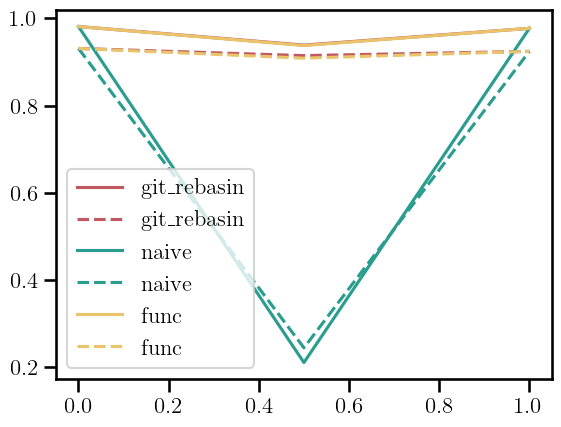

In [ ]:
results = {"git_rebasin": gitrebasin_results, "naive": naive_results, "func": func_results}
# plot train and test acc

for i, (method, method_results) in enumerate(results.items()):

    test_acc = method_results["test_acc"]
    train_acc = method_results["train_acc"]

    plt.plot(lambdas, train_acc, label=f"{method}", linestyle="solid", color=palette.get_colors(3)[i])
    plt.plot(lambdas, test_acc, label=f"{method}", linestyle="dashed", color=palette.get_colors(3)[i])

plt.legend()
plt.show()